# Hyperparameters search with Bayesian optimisation

In [1]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

## 1) Data gathering

In [60]:
###############################
N = 15000
dt = 1e-2
pi = np.pi
nb_parts = 100
n_training = 5
n_testing = 5
n_folds = n_training + n_testing
###############################
phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
###############################
time = np.arange(0,N,1)
t = np.arange(0,N*dt,dt)
pend = SimplePendulum(mass=1, length=1, time=time, X0=np.array([deg2rad(0),0]), dt=dt)
###############################
pend.ref = np.empty(shape=[n_folds,N])
for j in range(n_folds):
    x_train = 0
    phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
    f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
    A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
    for i in range(nb_parts):
        x_train = x_train + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    x_train = x_train/max(max(x_train),-min(x_train))*pi
    pend.ref[j,:] = x_train
###############################
Kp, Ki, Kd = 50, 20, 5
pend.U = np.zeros(shape=[n_folds,N-1])
pend.X = np.zeros(shape=[n_folds,2,N])
###############################
for j in range(n_folds):
    pend.X[j,0,0] = pend.ref[j,0]
    for i in range(N-1):
        pend.U[j,i] = PID(pend.X[j,:,:], i, pend.ref[j,i], Kp, Kd, Ki, pend.dt, 20, limit=[-20,20])[0] 
        pend.X[j,:,i+1] = RK4(pend.dynamics, pend.X[j,:,i], pend.U[j,i], pend.dt, type='controller-step-by-step')

## Hyperparameters tunign using *hyperopt*

In [171]:
# Hyperparameters space
traj_ratio = .05
n_low, n_high = 20, 100
d_low, d_high = 10, np.int((1-traj_ratio)/n_high*pend.N)
#######################################################
space = {
    "dimension": hp.quniform("dimension", 4, 20, 1),
    "nb_trajectories": hp.quniform("nb_trajectories", n_low, n_high, 1),
    "nb_delays": hp.quniform("nb_delays", d_low, d_high, 1),
}
#######################################################
loss_traj = np.empty(shape=[n_training])
loss_res = np.empty(shape=[n_training])
def hyperparameters_tuning(params):
    model1 = HAVOK(pend.X[0,:,:], pend.U[0,:])
    model1.HANKEL(np.int(params["nb_trajectories"]), np.int(params["nb_delays"]))
    model1.SVD(np.int(params["dimension"]))
    model1.LS(np.int(params["dimension"]),rcond=0)
    
    for fold in range(n_training):
        model1 = HAVOK(pend.X[fold,:,:], pend.U[fold,:])
        model1.HANKEL(np.int(params["nb_trajectories"]), np.int(params["nb_delays"]))
        model1.SVD(np.int(params["dimension"]))
        model1.LS(np.int(params["dimension"]),rcond=0)
        model1.Simulate(pend.X[fold,:,0],U_testing = pend.U[fold,:])
        model1.TrajError(pend.X[fold,:,:])
        loss_traj[fold] = lg.norm(model1.traj_error,2)
#         loss_res[fold] = np.sqrt(np.square(model1.residuals.sum()))

    loss = loss_traj.sum()/n_training
    
    return {"loss":loss, "status":STATUS_OK}
#######################################################
trials = Trials()

best = fmin(
    fn = hyperparameters_tuning,
    space = space, 
    algo = tpe.suggest, 
    max_evals = 200, 
    trials = trials
)

print('Best hyperparameters {}'.format(best))

 16%|███████▊                                       | 33/200 [00:36<02:37,  1.06trial/s, best loss: 199.36620883763322]

C:\Users\cedri\OneDrive\Documents\Mécanique - EPFL\Master III\Semester project\Software\My code\Subspace-learning-for-robot-application\LQR simulation\Utils\Functions.py:454: RuntimeWarning: overflow encountered in square
  self.residuals = (AB@self.YU - self.Y[:,1:self.Y.shape[1]])@(AB@self.YU - self.Y[:,1:self.Y.shape[1]]).T

C:\Users\cedri\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)



100%|██████████████████████████████████████████████| 200/200 [03:58<00:00,  1.19s/trial, best loss: 168.79142176230772]
Best hyperparameters {'dimension': 12.0, 'nb_delays': 82.0, 'nb_trajectories': 84.0}


## Training performance

Loss =  101.73706266429784
[[-0.02947 -0.07761 -0.04697 -0.07376  0.00312  0.01285 -0.01879  0.07923
   0.03528  0.01895  0.10257 -0.01694]] [[-0.02947 -0.07761 -0.04697 -0.07376  0.00312  0.01285 -0.01879  0.07923
   0.03528  0.01895  0.10257 -0.01694]]


(Text(0, 0.5, 'Degrees'), Text(0, 0.5, 'Degrees/sec'))

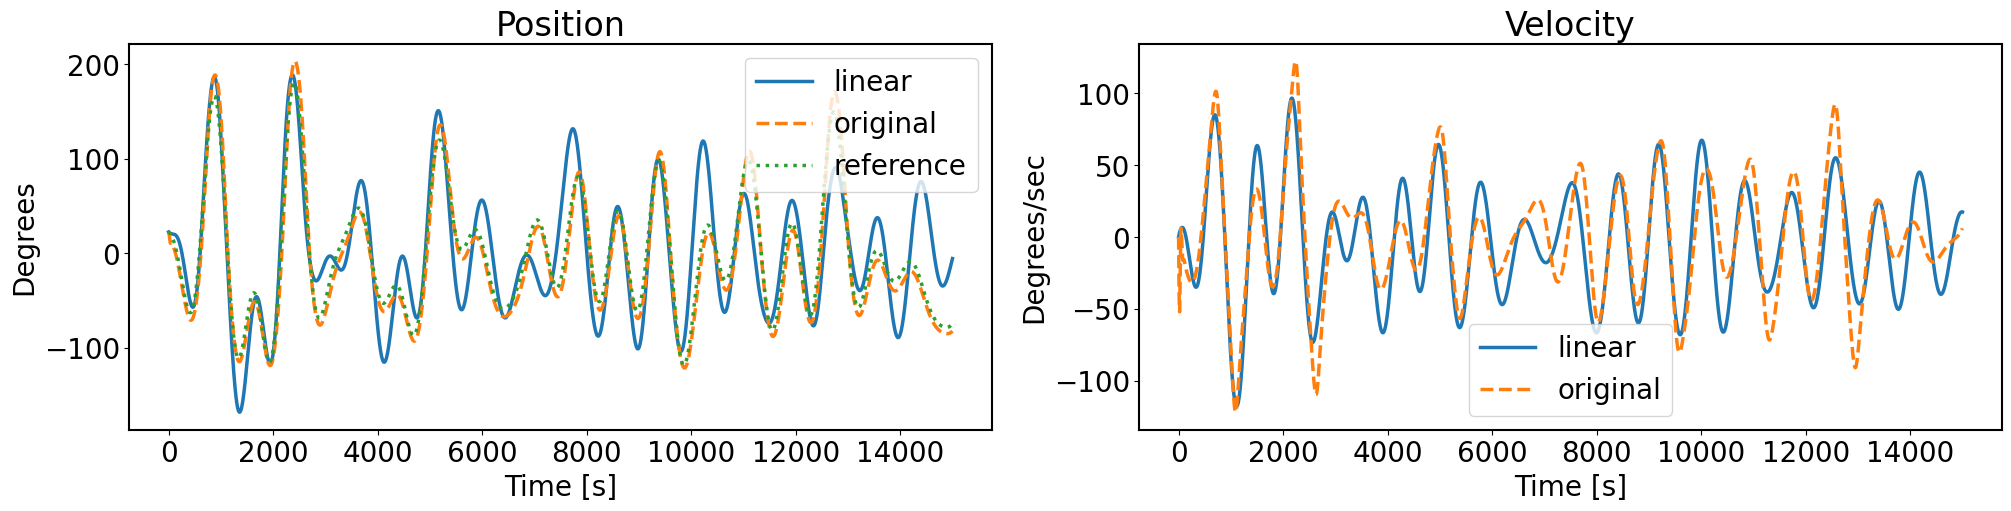

In [172]:
tau = 12
# Training
train = 0
model1 = HAVOK(pend.X[train,:,:], pend.U[train,:])
horizon = 84
model1.HANKEL(horizon, delay_spacing=82)
model1.SVD(tau)
model1.LS(tau,rcond=0)
model1.Simulate(pend.X[train,:,0],U_testing = pend.U[train,:])
model1.TrajError(pend.X[train,:,:])
print('Loss = ',lg.norm(model1.traj_error,2))
print(model1.Cu, model1.Cu1)

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(ncols=2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(pend.T,rad2deg(model1.X_traj[0,:]),label='linear'), ax[1].plot(pend.T,rad2deg(model1.X_traj[1,:]),label='linear')
ax[0].plot(pend.T,rad2deg(pend.X[train,0,:]),label='original',linestyle='dashed'), ax[1].plot(pend.T,rad2deg(pend.X[train,1,:]),label='original',linestyle='dashed')
ax[0].plot(pend.T,rad2deg(np.array(pend.ref[train,:])),linestyle='dotted',label='reference'), ax[0].legend(), ax[1].legend()
ax[0].set_title('Position'), ax[1].set_title('Velocity')
ax[0].set_xlabel('Time [s]'), ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('Degrees'), ax[1].set_ylabel('Degrees/sec')

# plt.savefig('Images/Midterm/Training.png',dpi=800)

## Testing performance

([<matplotlib.lines.Line2D at 0x235565a1c70>],
 <matplotlib.legend.Legend at 0x235565a1fd0>)

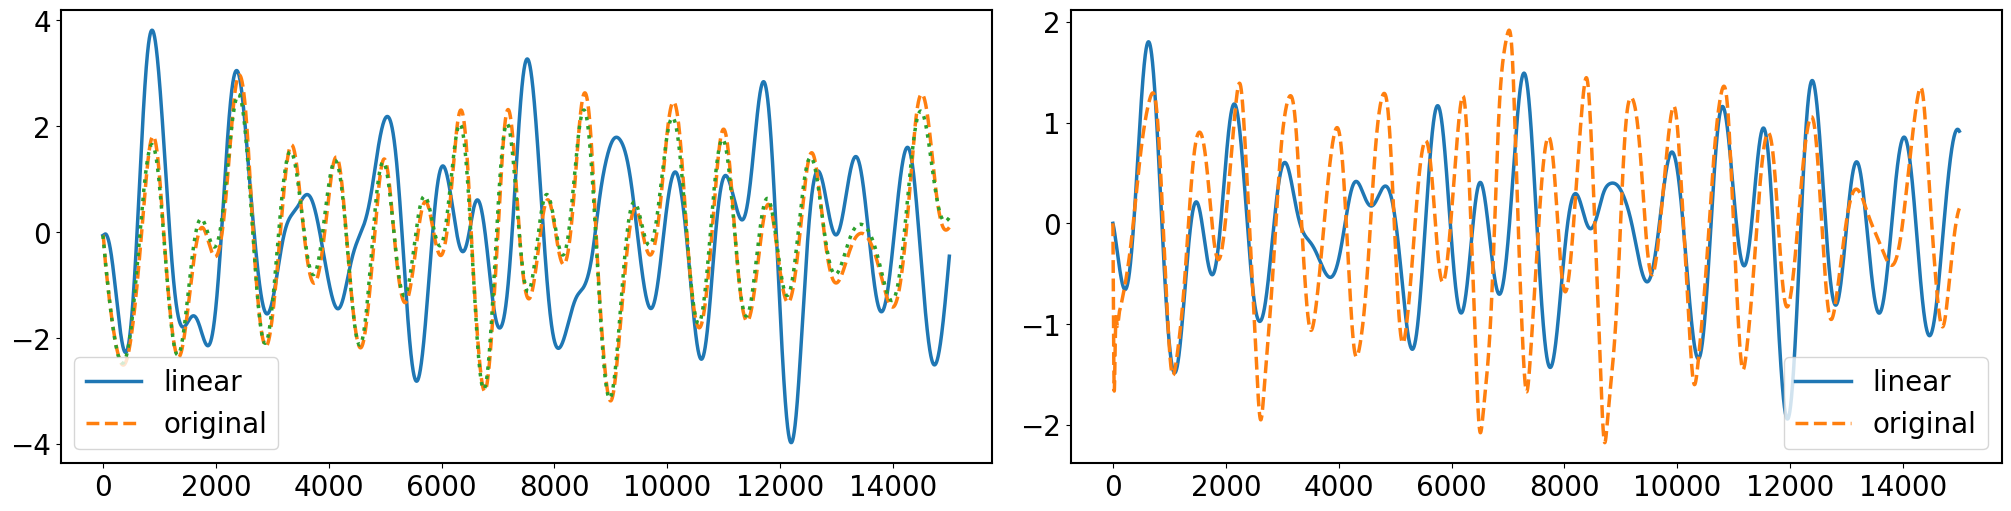

In [134]:
traj = 6
model1.Simulate(pend.X[traj,:,0],U_testing = pend.U[traj,:])
model1.TrajError(pend.X[traj,:,:])
##########################################
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(ncols=2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(model1.X_traj[0,:],label='linear'), ax[1].plot(model1.X_traj[1,:],label='linear')
ax[0].plot(pend.X[traj,0,:],label='original',linestyle='dashed'), ax[1].plot(pend.X[traj,1,:],label='original',linestyle='dashed')
ax[0].plot(np.array(pend.ref[traj,:]),linestyle='dotted'), ax[0].legend(), ax[1].legend()

## LQR testing

(1, 14999, 12)


(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(916.0786812221965, 0.5, 'Subspace coordinate $r$'))

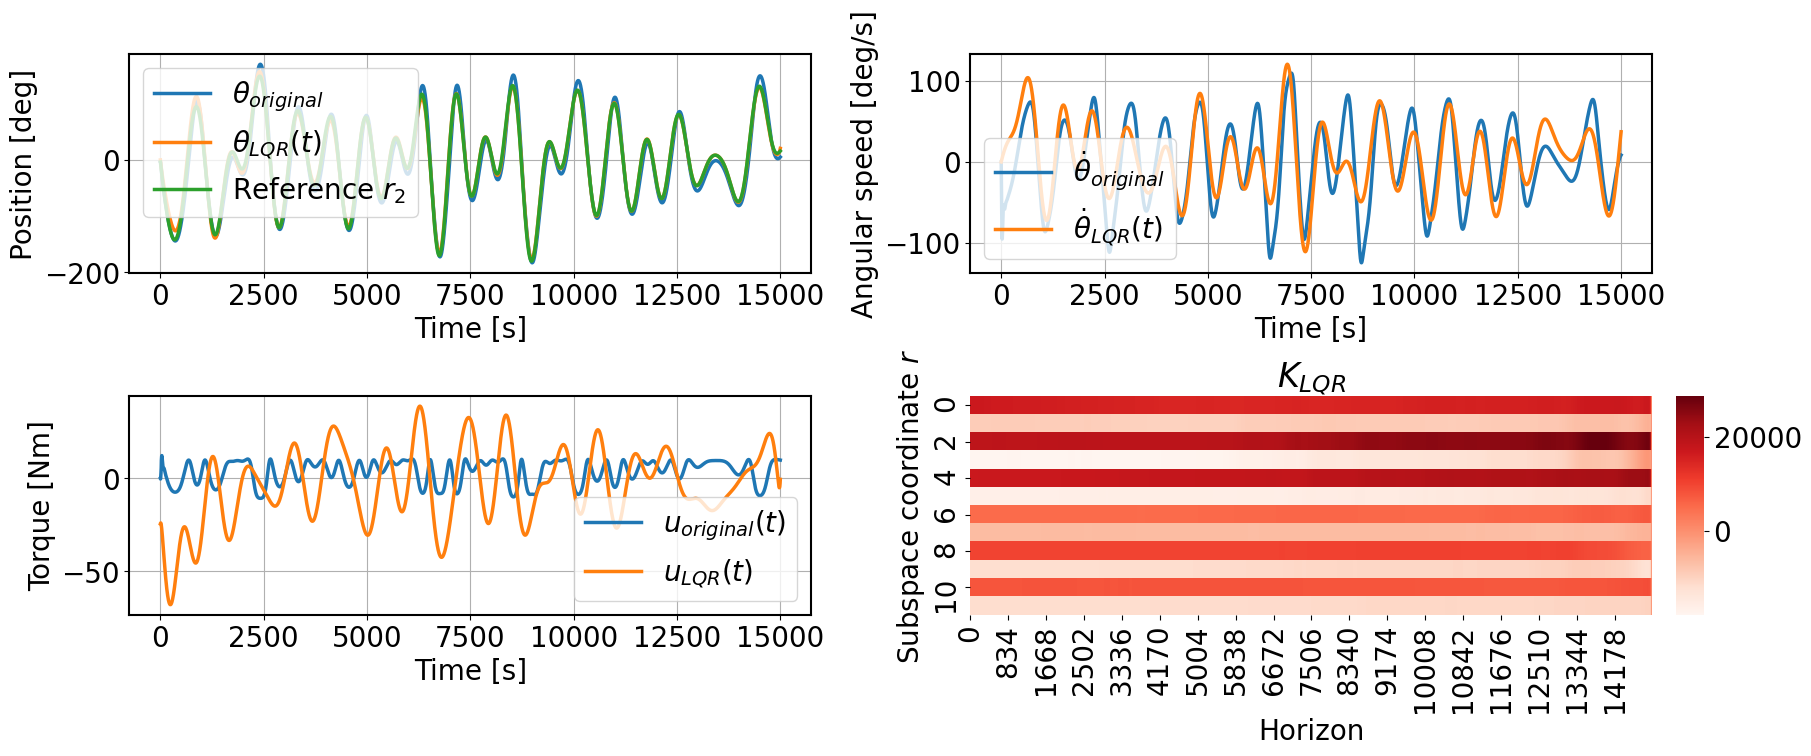

In [173]:
traj = 6
model1.Simulate(np.array([pend.ref[traj,0],0]), U_testing=pend.U[traj,:])
model1.ConstructLQR(x_std=1e6, u_std=1e-3, dt=pend.dt, ref=pend.ref[traj,:])
model1.LQR_simulate(pend.X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(pend.X[traj,0,:]), label=r'$\theta_{original}$')
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref[traj,:])), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(pend.X[traj,1,:]), label=r'$\dot{\theta}_{original}$')
ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

print(model1.LQR_U[:,:,:].shape)
ax[1,0].plot(pend.T[:model1.N-1], pend.U[traj,:], label='$u_{original}(t)$')
ax[1,0].plot(pend.T[:model1.N-1], (model1.Cu@model1.LQR_U[0,:,:].T).T, label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

LQR cost :  260281967305.48053
LQR cost :  900511437426.032


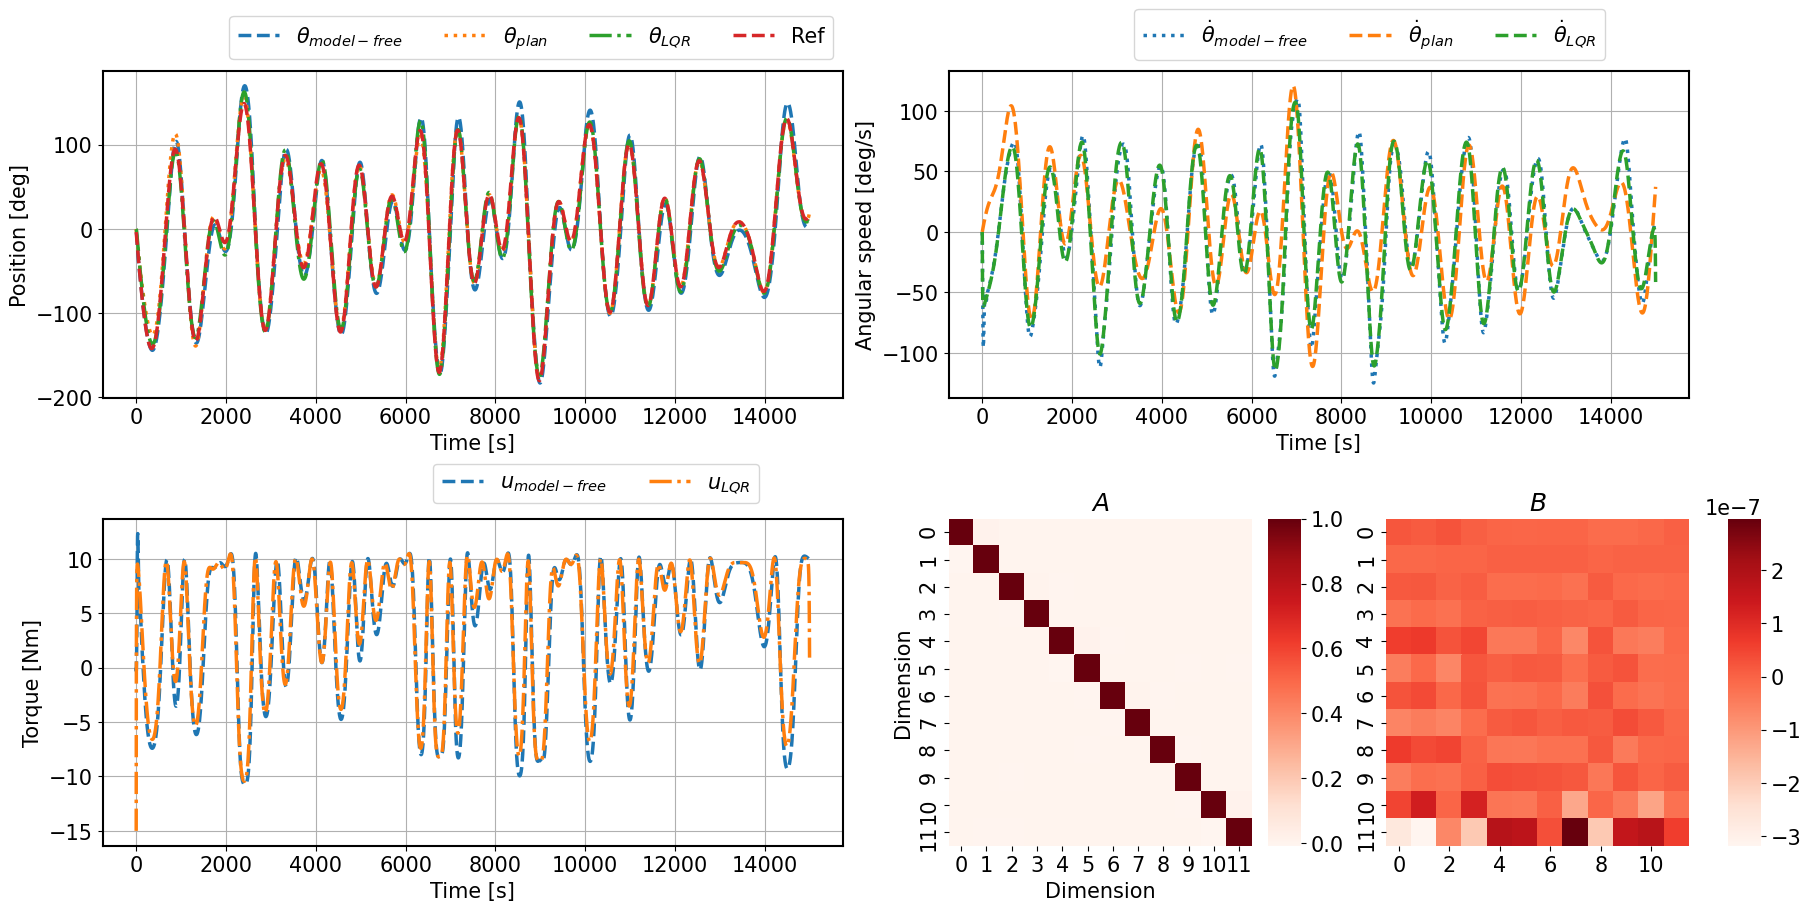

In [174]:
X0 = pend.X0
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-15,15] # Limiting contol input size

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = (model1.Cu@model1.LQR.get_command(Yc[:,i],i))
#     Uc[i] = (model1.LQR.get_command(Yc[:,i],i))[0]
    if Uc[i] >= u_max[1]: Uc[i] = u_max[1]
    if Uc[i] <= u_max[0]: Uc[i] = u_max[0]
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
print('LQR cost : ',model1.LQR_cost(Xc, Uc, pend.ref[traj,:]))
print('LQR cost : ',model1.LQR_cost(pend.X[traj,:,:], pend.U[traj,:], pend.ref[traj,:]))
    
# Plot
plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(18,9))

gs = fig.add_gridspec(8, 8)

ax00 = fig.add_subplot(gs[0:4,0:4])
ax01 = fig.add_subplot(gs[0:4,4:8])
ax10 = fig.add_subplot(gs[4:8,0:4])
ax11_0 = fig.add_subplot(gs[4:8,4:6])
ax11_1 = fig.add_subplot(gs[4:8,6:8])

ax00.plot(pend.T, rad2deg(pend.X[traj,0,:]), linestyle='dashed', label=r'$\theta_{model-free}$')
ax00.plot(pend.T, rad2deg(model1.LQR_X[:,0]), linestyle=':', label=r'$\theta_{plan}$')
ax00.plot(pend.T, rad2deg(Xc[0,:]), linestyle='dashdot', label=r"$\theta_{LQR}$")
ax00.plot(pend.T, rad2deg(np.array(pend.ref[traj,:])), linestyle='dashed', label='Ref')
ax00.set_xlabel('Time [s]'), ax00.set_ylabel('Position [deg]')
ax00.grid()
ax00.legend(bbox_to_anchor=(1, 1.2),ncol=5)

ax01.plot(pend.T, rad2deg(pend.X[traj,1,:]), linestyle='dotted', label=r'$\dot{\theta}_{model-free}$')
ax01.plot(pend.T, rad2deg(model1.LQR_X[:,1]), linestyle='dashed', label=r"$\dot{\theta}_{plan}$")
ax01.plot(pend.T, rad2deg(Xc[1,:]), linestyle='dashed', label=r"$\dot{\theta}_{LQR}$")
ax01.set_xlabel('Time [s]'), ax01.set_ylabel('Angular speed [deg/s]')
ax01.grid()
ax01.legend(bbox_to_anchor=(.9, 1.22),ncol=4)

ax10.plot(pend.T[:model1.N-1], pend.U[traj,:], linestyle='dashed', label='$u_{model-free}$')
# ax10.plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], linestyle='dotted', label='$u_{plan}$')
ax10.plot(pend.T[:model1.N-1], Uc, linestyle='dashdot', label='$u_{LQR}$')
ax10.set_xlabel('Time [s]'), ax10.set_ylabel('Torque [Nm]')
ax10.grid()
ax10.legend(bbox_to_anchor=(.9, 1.2),ncol=3)

ax11_0.set_title('$A$')
figA = snb.heatmap(model1.A,cmap='Reds',ax=ax11_0)
ax11_0.set_ylabel('Dimension'), ax11_0.set_xlabel('Dimension')

ax11_1.set_title('$B$')
figA = snb.heatmap(model1.B,cmap='Reds')

# fig.savefig('Images/Pend_HAVOK_trajectories_sine2.svg',format='svg',dpi=800)
# fig.savefig('Images/Midterm/summary.png',dpi=800)

## Pendulum swing up

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(913.4993836331583, 0.5, 'Subspace coordinate $r$'))

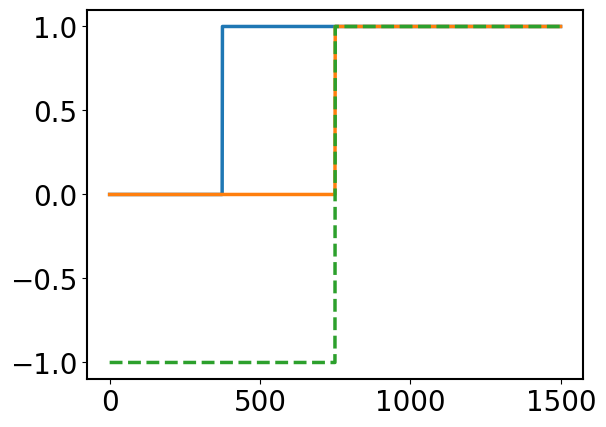

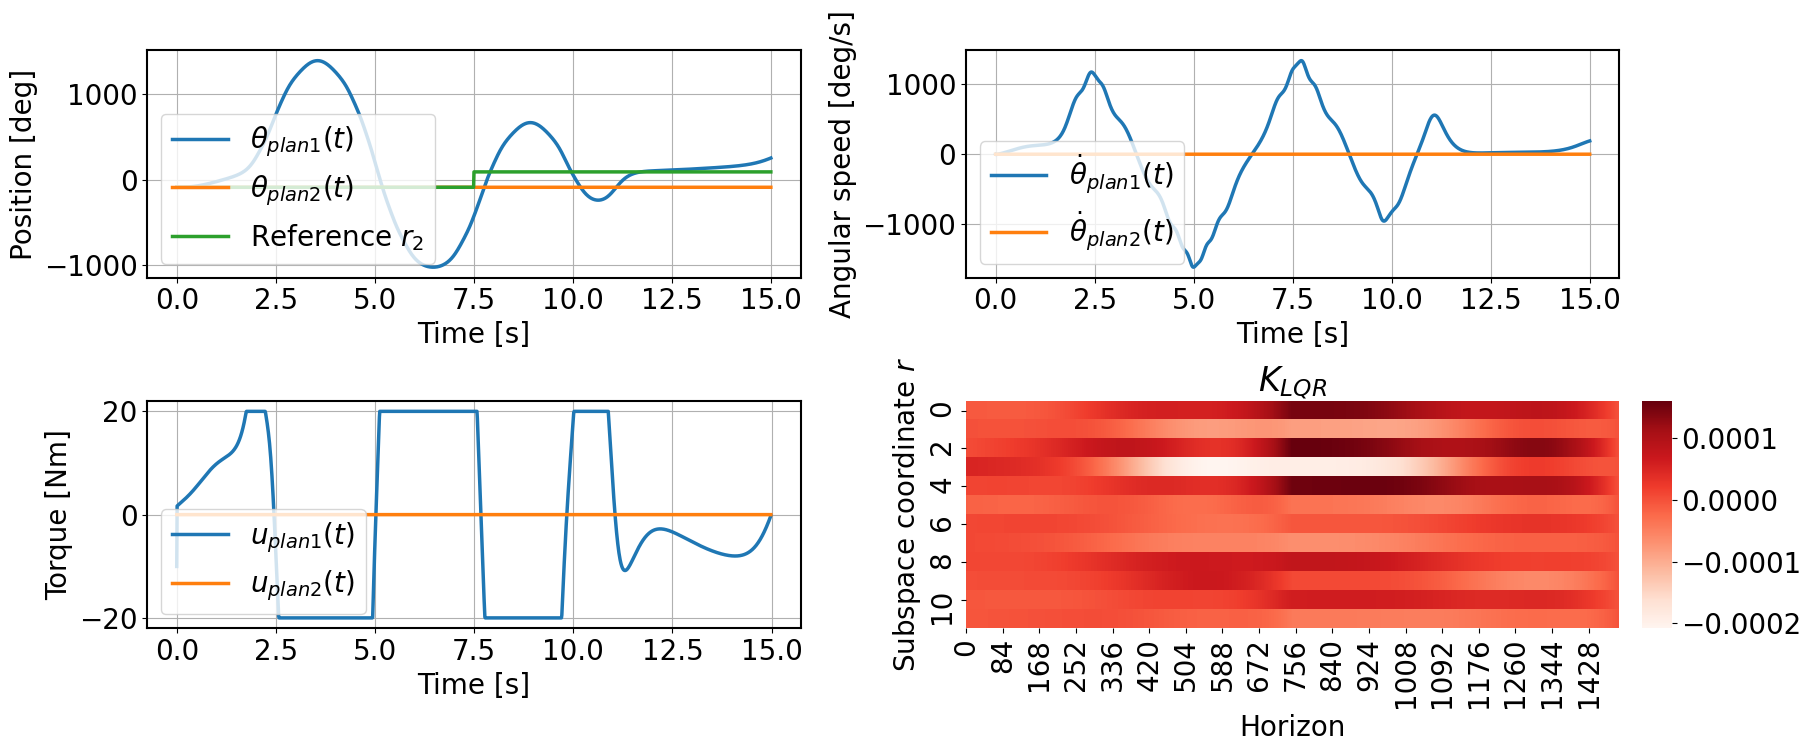

In [199]:
freq = .05
dt = 1e-2
period = 1/freq/dt
pend3 = SimplePendulum(mass=1, length=1, time=np.arange(0,15,dt), X0=np.array([deg2rad(120),0]), dt=dt)
pend = pend3
x_std = 1e7
pend.ref = np.zeros([2,pend.N])
# pend.ref[0,:] = sineReference(pend.N, pend.dt, period, 180, -90)
pend.ref[0,:] = np.hstack((deg2rad(-90)*np.ones(np.int(pend.N/2)),deg2rad(90)*np.ones(np.int(pend.N/2))))
precision1, precision2 = np.zeros(shape=[2,pend.N]), np.zeros(shape=[2,pend.N])
nb = np.int(pend.N/(period/2))

# precision[0,np.int(period/4)::np.int(period/2)] = x_std*np.ones(nb)
precision1[0,np.int(pend.N/4):pend.N] = np.ones(np.int(3*pend.N/4))*x_std
precision2[0,np.int(pend.N/2):pend.N] = np.ones(np.int(pend.N/2))*x_std
# precision2[0,:pend.N] = np.ones(np.int(pend.N))*x_std
plt.plot(precision1[0,:]/x_std)
plt.plot(precision2[0,:]/x_std)
plt.plot(pend.ref[0,:]/deg2rad(90),linestyle='dashed')

u_std = 29e-1
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, horizon=pend.N, custom_trajectory=precision1)
model1.LQR_simulate(np.array([deg2rad(-90),0]))
LQR1_X, LQR1_U, LQR1 = model1.LQR_X, model1.LQR_U, model1.LQR
u_std = 100e-1
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, horizon=pend.N, custom_trajectory=precision2)
model1.LQR_simulate(np.array([deg2rad(-90),0]))
LQR2_X, LQR2_U, LQR2 = model1.LQR_X, model1.LQR_U, model1.LQR

# # Plot
# plt.rcParams['font.size'] = 20
# fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

# ax[0,0].plot(pend.T, rad2deg(LQR1_X[:,0]), label=r"$\theta_{LQR1} (t)$")
# ax[0,0].plot(pend.T, rad2deg(LQR2_X[:,0]), label=r"$\theta_{LQR2} (t)$")
# ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
# ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
# ax[0,0].grid()
# ax[0,0].legend()

# ax[0,1].plot(pend.T, rad2deg(LQR1_X[:,1]), label=r"$\dot{\theta}_{LQR1} (t)$")
# ax[0,1].plot(pend.T, rad2deg(LQR2_X[:,1]), label=r"$\dot{\theta}_{LQR2} (t)$")
# ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
# ax[0,1].grid()
# ax[0,1].legend()

# ax[1,0].plot(pend.T[:pend.N-1], (model1.Cu@LQR1_U[0,:,:].T).T, label='$u_{LQR1}(t)$')
# ax[1,0].plot(pend.T[:pend.N-1], (model1.Cu@LQR2_U[0,:,:].T).T, label='$u_{LQR2}(t)$')
# ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
# ax[1,0].grid()
# ax[1,0].legend()

# ax[1,1].set_title('$K_{LQR}$')
# figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
# ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

X0 = np.array([deg2rad(-90),0])
Xc, Yc = np.zeros(shape=[2,model1.nb_S,pend.N]), np.zeros(shape=[2,model1.tau,pend.N])
Uc = np.empty(shape=[2,pend.N-1])
t_interval = pend.dt
LQR = np.array([LQR1,LQR2])

# Initial condition
Xc[:,:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-20,20]

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(pend.N-1):
    
    for j in range(2):
        Uc[j,i] = model1.Cu@LQR[j].get_command(Yc[j,:,i],i)
        
        if Uc[j,i] >= u_max[1]: Uc[j,i] = u_max[1]
        if Uc[j,i] <= u_max[0]: Uc[j,i] = u_max[0]

        Xc[j,:,i+1]= RK4(f, Xc[j,:,i], Uc[j,i], t_interval, type='controller-step-by-step')
        Yc[j,:,i+1] = pinv(model1.C)@Xc[j,:,i+1]
    
# # Evaluate LQR costs
# cost_roll = model1.LQR_cost(model1.LQR_X.T,model1.LQR_U[0,:,0],pend.ref[0,:],horizon=pend.N)
# cost_plan = model1.LQR_cost(Xc,Uc,pend.ref[0,:],horizon=pend.N)
# print('Rollout cost is ',cost_roll/cost_plan*100,' [%] of planning cost')
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(Xc[0,0,:]), label=r"$\theta_{plan1} (t)$")
ax[0,0].plot(pend.T, rad2deg(Xc[1,0,:]), label=r"$\theta_{plan2} (t)$")
ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[0,1,:]), label=r"$\dot{\theta}_{plan1} (t)$")
ax[0,1].plot(pend.T, rad2deg(Xc[1,1,:]), label=r"$\dot{\theta}_{plan2} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:pend.N-1], Uc[0,:], label='$u_{plan1}(t)$')
ax[1,0].plot(pend.T[:pend.N-1], Uc[1,:], label='$u_{plan2}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')